In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import sklearn.linear_model
import sklearn.model_selection
import random


rest = random.random()

def weight(word):
    # overfitted
    if word == 'lerxst@wam.umd.edu':
        return 100.0
    if word == 'car':
        return random.random()
    if word == 'dog':
        return - random.random()
    return random.random()

def has(word, text):
    return word in text 

# Applied Machine Learning

## Linear Models

### Recap

- We have some dataset
- We identify the problem and define the loss function
- Then we minimize the total loss (empirical risk) using available (training) data

### A text classification problem

Lets consider the **20 newsgroups** dataset:

In [37]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
text, label = data['data'][0], data['target_names'][data['target'][0]]
print(label); print(text[:300])

rec.autos
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be 


### A linear model for classification

Let us consider a function that tells if the `text` comes from `rec.autos`

In [39]:
score = weight('car')*has('car', text) + weight('dog')*has('dog', text) + rest
score

0.7825381468621476

How do we find those `weight` ($w$) for all the words?

### Gradient Descent

- Last time we used `opt.fmin` and it magically found the solution
- The method is simple though
- Start with random weights $w_0$
- Iterate: $w_{i+1} = w_{i} - \alpha \times \nabla \mathsf{objective}(w_i)$
- All we need to know is the gradient of objective

### Gradient of loss

- Last time we considered a regression problem and used $(y-p)^2$
- The gradient w.r.t $p$ is obvious: $- 2 (y - p)$

### Gradient check

How can we ensure the gradient is correct?

In [40]:
def loss(y, p):
    return (y-p)**2

def gradient(y, p):
    return -2*(y-p)

p = 0.1
y = 0.3
eps = 0.001
gradient(y, p), (loss(y, p+eps) - loss(y, p-eps)) / (2*eps)

(-0.39999999999999997, -0.400000000000001)

### Gradient descent in code

In [41]:
current_p = random.random()
alpha = 0.1

for i in range(5):
    current_p = current_p - alpha*gradient(y, current_p)
    print(i, current_p)

0 0.2597102416945659
1 0.2677681933556527
2 0.27421455468452216
3 0.27937164374761775
4 0.2834973149980942


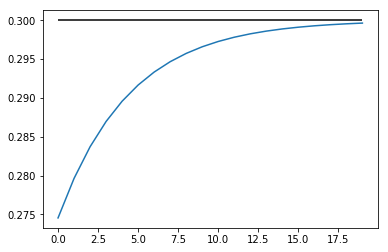

In [42]:
current_p = random.random()
alpha = 0.1

xs = list(range(20))
ys = []
for _ in xs:
    current_p = current_p - alpha*gradient(y, current_p)
    ys.append(current_p)
    
plt.plot(xs, ys); plt.hlines(y, xs[0], xs[-1]);

### Classification loss

- We will use something called **logistic loss**

In [43]:
def loss(y, p):
    return np.log2(1.0 + np.exp(-y*p))
    
loss(-1, -100.0), loss(-1, +100.0)

(0.0, 144.26950408889635)

### Overfitting

- We can always come up with a model that fits data perfectly

In [44]:
weight('lerxst@wam.umd.edu')

100.0

- For some reason that's not what we want

### Splitting the data

- Obviously we should not test what we fit against
- We should fit (train) the model on some part of data
- Next, we check the model against the rest

### Leave-on-out

- Generate as many samples as there are examples
- Gives you a good estimate if you don't have a lot of data
- Gets impractical on huge datasets

In [45]:
loo = sklearn.model_selection.LeaveOneOut()
for train, test in loo.split([1,2,3,4,5]):
    print(train, test)

[1 2 3 4] [0]
[0 2 3 4] [1]
[0 1 3 4] [2]
[0 1 2 4] [3]
[0 1 2 3] [4]


### Cross validation

- Split the dataset into a few (say 5) non-overlapping parts
- Four parts go to training data and one part goes to test data
- Do the above 5 times to train the model and test it
- Makes a decent way to *detect* overfitting

### Cross validation in sklearn

Let's consider indices of data

In [46]:
xval = sklearn.model_selection.KFold(n_splits=3)
for train, test in xval.split([1,2,3,4,5,6]):
    print(train, test)

[2 3 4 5] [0 1]
[0 1 4 5] [2 3]
[0 1 2 3] [4 5]


### Ill-posed problems

- A mathematical problem is ill-posed when the solution is not unique
- That's exactly the case of regression/classification/...
- We need to make the problem well-posed: *regularization*

### Structural risk minimization

- Structural risk is empirical risk plus regularizer
- Instead of minimizing empirical risk we find some tradeoff
- Regularizer is a function of model we get
- $\mathsf{objective} = \mathsf{loss} + \mathsf{regularizer}$

### Regularizer

- A functions that reflects the complexity of a model
- What is the complexity of a set of 'if ... then'?
- Not obvious for linear model but easy to invent something

### $\ell_1$ regularizer

- Derivative is const
- Forces weight to be zero if it doesn't hurt performance much 
- Use if you believe some features are useless

In [19]:
classification_model = sklearn.linear_model.LogisticRegression(penalty='l1');
regression_model = sklearn.linear_model.Lasso();

### $\ell_2$ regularizer

- Derivative is linear
- Forces weights to get *similar* magnitude if it doesn't hurt performance much
- Use if you believe all features are more or less important

In [20]:
classification_model = sklearn.linear_model.LogisticRegression(penalty='l2');
regression_model = sklearn.linear_model.Ridge();

### Elastic net

- Just a weighted sum of $\ell_1$ and $\ell_2$ regularizers
- An attempt to get useful properties of both

In [22]:
regression_model = sklearn.linear_model.ElasticNet()

### Limitation of linearity

- In low-dimensional spaces linear models are not very 'powerful' (can we define that?)
- The higher dimensionality, the more powerful linear model becomes

### Sparse features

- We say features are sparse when most of the values are zero
- Examples: visited hosts, movies that user liked, ...
- Sparse features are efficient in high-dimensional setting

### One hot encoding, hashing trick

- One way to encode categorical things like visited hosts
- We enumerate all the hosts
- We put 1 to position of every host, 0 otherwise
- Hashing trick: instead of enumerating them just hash

In [23]:
hash('hse.ru') % 2**16

24033

### Hashing vectorizer in sklearn

In [24]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=10, binary=True)
features = vectorizer.fit_transform(['hello there', 'hey there'])
print(features.todense())

[[0.         0.70710678 0.         0.         0.         0.
  0.         0.70710678 0.         0.        ]
 [0.         0.         0.         0.         0.70710678 0.
  0.         0.70710678 0.         0.        ]]


### When do we use linear models?

- It is definitely the first thing to try if you have some text data
- In general a good choice for any sparse data
- This approach is pretty much the fastest one
- Even if some method outperforms you still have a good baseline

### Homework 1

- No score, just have to be done
- For best score, deadline is next class
- Load dataset, create linear model, train, and explain results
- The template will be provided
- Hint: check the code examples for `KFold`, `HashingVectorizer`, `LogisticRegression`